In [1]:
import time
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

from fast_ml import eda

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
cudnn.benchmark=True

import mlflow
from mlflow import log_metric, log_param, log_artifacts, start_run, end_run
mlflow.set_tracking_uri("http://wob-srv-tiho.wob.dos.local:5555/")
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://wob-srv-tiho.wob.dos.local:9000/'
os.environ['AWS_ACCESS_KEY_ID'] = 'konstantin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'konstantin1234'

In [2]:
# mlflow.create_experiment('test_km')
mlflow.set_experiment('test_km')

<Experiment: artifact_location='s3://mlflow/2', experiment_id='2', lifecycle_stage='active', name='test_km', tags={}>

In [3]:
def show_one_image(image, label):
    
    if torch.is_tensor(image):
        plt.imshow(image.permute(1, 2, 0))
    else:
        plt.imshow(image)
    lab = label
    plt.xlabel(lab)
    
def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (20,20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images,nrow=batch_size).permute(1,2,0))
        break

In [4]:
base_path='c:/Users/konstantin.moeller/python/ki_in_mrt'

In [5]:
df=pd.read_csv('{}/_converted.csv'.format(base_path))
df['png_file']=df['png_file'].str.replace('.',base_path, 1, regex=True)

In [6]:
summary_df=eda.df_info(df)
summary_df

data_type data_type_grp num_unique_values  \
filenames          object   Categorical             61206   
source             object   Categorical                 2   
patient_id         object   Categorical               266   
patient_name       object   Categorical               266   
scan               object   Categorical                18   
scan_art           object   Categorical                 3   
scan_ebene         object   Categorical                 3   
contrast             bool          bool                 2   
v7_file            object   Categorical              2166   
image              object   Categorical             51462   
multiple_images      bool          bool                 2   
frame               int64     Numerical               181   
png_file           object   Categorical             64149   

                                              sample_unique_values  \
filenames        [./source/rvc/0773_495950_Booth_Splodge/0773_4...   
source                                                 [rvc, tiho]   
patient_id       [0773_495950, 0776_459843, 0778_436960, 0781_5...   
patient_name     [Booth_Splodge, Onisiforou_Rocco, Desilva_Zeus...   
scan             [T1_DOR_GAD, T1_SAG_GAD, T1_TRA, T1_TRA_GAD, T...   
scan_art                                         [T1, T2FLAIR, T2]   
scan_ebene                                         [DOR, SAG, TRA]   
contrast                                             [True, False]   
v7_file          [0773_495950_T1_DOR_GAD, 0773_495950_T1_SAG_GA...   
image            [IM-0006-0001.dcm, IM-0006-0002.dcm, IM-0006-0...   
multiple_images                                      [False, True]   
frame                               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]   
png_file         [c:/Users/konstantin.moeller/python/ki_in_mrt/...   

                num_missing perc_missing  
filenames                 0          0.0  
source                    0          0.0  
patient_id                0          0.0  
patient_name              0          0.0  
scan                      0          0.0  
scan_art                  0          0.0  
scan_ebene                0          0.0  
contrast                  0          0.0  
v7_file                   0          0.0  
image                     0          0.0  
multiple_images           0          0.0  
frame                     0          0.0  
png_file                  0          0.0

In [7]:
df['scan_art'].value_counts()

T1         43277
T2         14484
T2FLAIR     6388
Name: scan_art, dtype: int64

In [8]:
class_map={'T1':0, 'T2':1, 'T2FLAIR':2}

In [9]:
data=df[['png_file','scan_art']]
data

png_file scan_art
0      c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T1
1      c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T1
2      c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T1
3      c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T1
4      c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T1
...                                                  ...      ...
64144  c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T2
64145  c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T2
64146  c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T2
64147  c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T2
64148  c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T2

[64149 rows x 2 columns]

In [10]:
data['png_file'].iloc[0]

'c:/Users/konstantin.moeller/python/ki_in_mrt/_png/0773_495950_T1_DOR_GAD/0000000.png'

In [11]:
data['png_file'].iloc[1]

'c:/Users/konstantin.moeller/python/ki_in_mrt/_png/0773_495950_T1_DOR_GAD/0000001.png'

In [12]:
data_t1=data[data['scan_art']=='T1'].sample(n=800).reset_index(drop=True)
data_t2=data[data['scan_art']=='T2'].sample(n=800).reset_index(drop=True)
data_t2f=data[data['scan_art']=='T2FLAIR'].sample(n=800).reset_index(drop=True)

In [13]:
train=pd.concat([data_t1[0:600], data_t2[0:600], data_t2f[0:600]], axis=0).sample(frac=1).reset_index(drop=True)
test=pd.concat([data_t1[600:700], data_t2[600:700], data_t2f[600:700]], axis=0).sample(frac=1).reset_index(drop=True)
valid=pd.concat([data_t1[700:], data_t2[700:], data_t2f[700:]], axis=0).sample(frac=1).reset_index(drop=True)

In [14]:
train['png_file'].iloc[0]

'c:/Users/konstantin.moeller/python/ki_in_mrt/_png/0074_T0392002_T2_TRA/0000017.png'

In [15]:
data['png_file'].iloc[1]

'c:/Users/konstantin.moeller/python/ki_in_mrt/_png/0773_495950_T1_DOR_GAD/0000001.png'

In [16]:
train

png_file scan_art
0     c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T2
1     c:/Users/konstantin.moeller/python/ki_in_mrt/_...  T2FLAIR
2     c:/Users/konstantin.moeller/python/ki_in_mrt/_...  T2FLAIR
3     c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T2
4     c:/Users/konstantin.moeller/python/ki_in_mrt/_...  T2FLAIR
...                                                 ...      ...
1795  c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T1
1796  c:/Users/konstantin.moeller/python/ki_in_mrt/_...  T2FLAIR
1797  c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T2
1798  c:/Users/konstantin.moeller/python/ki_in_mrt/_...  T2FLAIR
1799  c:/Users/konstantin.moeller/python/ki_in_mrt/_...       T2

[1800 rows x 2 columns]

In [17]:
test['scan_art'].value_counts()

T2FLAIR    100
T1         100
T2         100
Name: scan_art, dtype: int64

In [18]:
class dog_brain_data(Dataset):
    def __init__(self, dataframe, transform=transforms.Compose([transforms.Resize((500,500))])):
        self.dataframe = dataframe
        self.transform = transform
        self.class_map=class_map
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        row=self.dataframe.iloc[index]
        image=read_image(row[0])
        label=row[1]
        label=self.class_map[label]
        
        if self.transform:
            image=self.transform(image)
            
        return image, label

In [19]:
train_data=dog_brain_data(train)
test_data=dog_brain_data(test)
valid_data=dog_brain_data(valid)

In [20]:
train_data

In [21]:
batch_size=8
num_epochs=50

learning_rate=0.1

In [22]:
train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)
test_loader=torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)
valid_loader=torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=0)

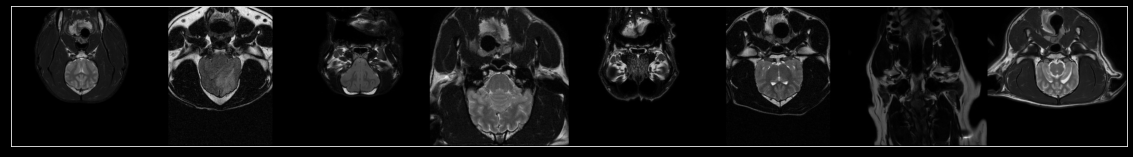

In [23]:
show_batch(train_loader)

In [24]:
dataloaders = {'train': train_loader, 'valid':valid_loader}

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [26]:
model = models.resnet50(pretrained=True)

In [27]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
model.fc=torch.nn.Sequential(torch.nn.Linear(in_features=2048, out_features=3), torch.nn.Sigmoid())

In [29]:
model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [30]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters())
scheduler = torch.optim.lr_scheduler

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since=time.time()
    
    model=model.to(device)
    
    best_model_wts=copy.deepcopy(model.state_dict())
    best_acc=0.0
    
    end_run()
    start_run()
    log_param('batch_size', batch_size)
    log_param('epochs', num_epochs)
    # log_param('model_name', 'pretrained resnet50')
    log_param('initial learning rate', learning_rate)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('_'*10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                   
            running_loss=0.0
            running_corrects=0
            
            for inputs, labels in dataloaders[phase]:
                inputs=inputs.float().to(device)
                labels=labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                _, preds = torch.max(outputs, 1)        
                    
                    
                outputs=model(inputs)
                loss=criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)
                
            epoch_loss=running_loss/len(dataloaders[phase].dataset)
            epoch_acc=running_corrects.double()/len(dataloaders[phase].dataset)
            
            time_elapsed=time.time()-since
            
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            if phase == 'valid':
                log_metric('val_loss', epoch_loss)
                log_metric('val_acc', epoch_acc.item())
            else:
                log_metric('train_loss', epoch_loss)
                log_metric('train_acc', epoch_acc.item())
            
            if phase == 'valid' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
                best_epoch=epoch

        
    time_elapsed=time.strftime('%H:%M:%S', time.gmtime(time_elapsed))            
    print('Training finished!')
    print('_'*10)
    print('Best model: {} epoch, with {:.4f} validation accuracy after training for {}'.format(best_epoch+1, best_acc, time_elapsed))
    model.load_state_dict(best_model_wts)
    
    mlflow.pytorch.log_model(model, '{}_{}of{}_{:.4f}'.format('pretrained resnet50',best_epoch+1, num_epochs, best_acc))
    end_run()              
    return model

In [33]:
model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

2022/05/10 12:30:04 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Epoch 1/50
__________
train loss: 0.9808, acc: 0.5517
<class 'torch.Tensor'> tensor(0.5517, device='cuda:0', dtype=torch.float64)
valid loss: 0.8500, acc: 0.7867
Epoch 2/50
__________
train loss: 0.8681, acc: 0.7089
<class 'torch.Tensor'> tensor(0.7089, device='cuda:0', dtype=torch.float64)
valid loss: 0.8060, acc: 0.8033
Epoch 3/50
__________
train loss: 0.8306, acc: 0.7533
<class 'torch.Tensor'> tensor(0.7533, device='cuda:0', dtype=torch.float64)
valid loss: 0.7831, acc: 0.8167
Epoch 4/50
__________
train loss: 0.8095, acc: 0.7761
<class 'torch.Tensor'> tensor(0.7761, device='cuda:0', dtype=torch.float64)
valid loss: 0.7666, acc: 0.8267
Epoch 5/50
__________
train loss: 0.7951, acc: 0.7872
<class 'torch.Tensor'> tensor(0.7872, device='cuda:0', dtype=torch.float64)
valid loss: 0.7541, acc: 0.8300
Epoch 6/50
__________
train loss: 0.7842, acc: 0.7944
<class 'torch.Tensor'> tensor(0.7944, device='cuda:0', dtype=torch.float64)
valid loss: 0.7443, acc: 0.8333
Epoch 7/50
__________
train 

2022/05/10 13:44:03 WARNING mlflow.utils.requirements_utils: Found torch version (1.10.2+cu113) contains a local version label (+cu113). MLflow logged a pip requirement for this package as 'torch==1.10.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Training finished!
__________
Best model: 46 epoch, with 0.8767 validation accuracy after training for 01:13:59


2022/05/10 13:44:10 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.11.3+cu113) contains a local version label (+cu113). MLflow logged a pip requirement for this package as 'torchvision==0.11.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [ ]:
torch.save(model_trained, '{}/model/resnet_50'.format(base_path))